## Notebook for extracting ECG signals from the PhysioNet MIT-BIH Arrhythmia Database

<https://physionet.org/content/mitdb/1.0.0/>

## To-Do:

**✅ Save the first 5 minutes, the remaining 25 minutes (with arrhythmia from the first 5 minutes), and the whole 30-minute recording.**

**✅ Take only the healthy signals in the first five minutes.**

**✅ Detrend and normalize the beats.**
 
**✅ Annotate them to their labels.**

**✅ Don't use your own rpeak detector, as it misses arrhythmia beats.**

**✅ Make sure to use 64 bit precision, or check which precision is used in the MATLAB signals.**

**✅ Read the MIT-BIH data as ECG signals.**

In [1]:
import wfdb
import numpy as np
import pandas as pd
import scipy as sp
from scipy import io as sio
from scipy import signal as sps
import matplotlib.pyplot as plt

#from ecgdetectors import Detectors  # not used, misses arrhythmia beats, can comment out.

import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict
import pickle
import json

# custom libraries
from progress_bar import print_progress

In [2]:
DATA_ROOT = osj("..", "physionet.org/files/mitdb/1.0.0")
RECORDS = osj(DATA_ROOT, "RECORDS")

# 01 Get data
## Get patient ids
These are the Patient IDs, from 100 to 234, sorted but not consecutive.

In [3]:
patient_ids = pd.read_csv(RECORDS, delimiter="\n", header=None).to_numpy().reshape(-1)

In [4]:
patient_ids

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
       114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
       203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
       221, 222, 223, 228, 230, 231, 232, 233, 234])

## Get ECG signals and ECG info
Read the ECG signals and some information about them. This loads the 2-leads into the corresponding variables.

In [ ]:
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, _ = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
    return lead0, lead1

# Change: added medication to be extracted
def get_ecg_info(patient_ids):
    info = {} # patient info
    med = {} # medication
    for id_ in patient_ids:
        _, info_ = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        info[id_] = info_["comments"][0]
        med[id_] = info_["comments"][1]
        #info[id_]["resolution"] = 2**11 # Number of possible signal values we can have. # 650000 for all patients
    return info, med

In [6]:
lead0, lead1 = get_ecg_signals(patient_ids)

In [20]:
ecg_info, medication = get_ecg_info(patient_ids)

In [21]:
ecg_info

{100: '69 M 1085 1629 x1',
 101: '75 F 1011 654 x1',
 102: '84 F 1525 167 x1',
 103: '-1 M 742 654 x1',
 104: '66 F 1567 694 x1',
 105: '73 F 1624 1629 x1',
 106: '24 F 1581 654 x1',
 107: '63 M 1340 167 x1',
 108: '87 F 1227 654 x1',
 109: '64 M 1508 694 x1',
 111: '47 F 937 167 x1',
 112: '54 M 903 654 x2',
 113: '24 F 1240 2851 x1',
 114: '72 F 750 1629 x1',
 115: '39 F 994 167 x2',
 116: '68 M 1453 1629 x2',
 117: '69 M 950 654 x2',
 118: '69 M 1456 653 x2',
 119: '51 F 1129 654 x2',
 121: '83 F 1245 167 x2',
 122: '51 M 640 654 x2',
 123: '63 F 1482 694 x2',
 124: '77 M 1199 653 x2',
 200: '64 M 1953 3655 x1',
 201: '68 M 1960 2851 x1',
 202: '68 M 1960 2851 x1',
 203: '43 M 1878 356 x1',
 205: '59 M 1957 694 x2',
 207: '89 F 859 694 x1',
 208: '23 F 2546 N/A x1',
 209: '62 M 1202 654 x1',
 210: '89 M 2461 694 x1',
 212: '32 F 2879 171 x1',
 213: '61 M 2817 1629 x1',
 214: '53 M 3189 1629 x1',
 215: '81 M 2633 694 x1',
 217: '65 M 2450 653 x1',
 219: '-1 M 978 654 x1',
 220: '87 F

In [22]:
medication

{100: 'Aldomet, Inderal',
 101: 'Diapres',
 102: 'Digoxin',
 103: 'Diapres, Xyloprim',
 104: 'Digoxin, Pronestyl',
 105: 'Digoxin, Nitropaste, Pronestyl',
 106: 'Inderal',
 107: 'Digoxin',
 108: 'Digoxin, Quinaglute',
 109: 'Quinidine',
 111: 'Digoxin, Lasix',
 112: 'Digoxin, Pronestyl',
 113: 'None',
 114: 'Digoxin',
 115: 'None',
 116: 'None',
 117: 'None',
 118: 'Digoxin, Norpace',
 119: 'Pronestyl',
 121: 'Digoxin, Isordil, Nitropaste',
 122: 'Digoxin, Lasix, Pronestyl',
 123: 'Digoxin, Inderal',
 124: 'Digoxin, Isordil, Quinidine',
 200: 'Digoxin, Quinidine',
 201: 'Digoxin, Hydrochlorthiazide, Inderal, KCl',
 202: 'Digoxin, Hydrochlorthiazide, Inderal, KCl',
 203: 'Coumadin, Digoxin, Heparin, Hygroton, Lasix',
 205: 'Digoxin, Quinaglute',
 207: 'Digoxin, Quinaglute',
 208: 'None',
 209: 'Aldomet, Hydrodiuril, Inderal',
 210: 'None',
 212: 'None',
 213: 'Digoxin',
 214: 'Digoxin, Dilantin',
 215: 'None',
 217: 'Digoxin, Lasix, Quinidine',
 219: 'Digoxin',
 220: 'Digoxin',
 221: 'H

Get patients with a pacemaker

Comment: Moved this up from below, the patients are not used in this script.

In [ ]:
def get_paced_patients(patient_ids):
    paced = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        if ("/" in labels):
            paced.append(id_)
    return np.array(paced)

In [ ]:
paced_patients = get_paced_patients(patient_ids)
paced_patients

## store patient info (added)
Patient info contains the age, gender, and medications. This information will be used later to evaluate privacy.

In [30]:
df_patient = pd.DataFrame.from_dict(ecg_info, orient="index", columns=["info"])
df_patient["medication"] = pd.Series(medication)

In [31]:
df_patient.head()

,info,medication
100,69 M 1085 1629 x1,"Aldomet, Inderal"
101,75 F 1011 654 x1,Diapres
102,84 F 1525 167 x1,Digoxin
103,-1 M 742 654 x1,"Diapres, Xyloprim"
104,66 F 1567 694 x1,"Digoxin, Pronestyl"


In [32]:
# split the comment into its components & drop irrevelant columns
df_patient[['age', 'gender', 'value1', 'value2', 'x']] = df_patient["info"].str.split(' ', expand=True)
df_patient.drop(columns=["info", 'value1', 'value2', 'x'], inplace=True)

In [33]:
df_patient.head()

,medication,age,gender
100,"Aldomet, Inderal",69,M
101,Diapres,75,F
102,Digoxin,84,F
103,"Diapres, Xyloprim",-1,M
104,"Digoxin, Pronestyl",66,F


In [34]:
df_patient['gender'].value_counts()

M    26
F    22
Name: gender, dtype: int64

# 02 Get peaks and labels 
Annotations contain peak locations, and their labels (N, V, S, etc.).
- **annotation.sample contains the indices**
- **annotation.symbol contains the labels**
- **use help(wfdb.Record), help(wfdb.Annotation) for more info**

In [45]:
def get_all_beat_labels(patient_ids):
    all_labels = []
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        labels = np.unique(annotation.symbol)
        all_labels.extend(labels)
    return np.unique(all_labels)

In [46]:
all_beat_labels = get_all_beat_labels(patient_ids)

In [47]:
all_beat_labels

array(['!', '"', '+', '/', 'A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S',
       'V', '[', ']', 'a', 'e', 'f', 'j', 'x', '|', '~'], dtype='<U1')

In [48]:
def get_rpeaks_and_labels(patient_ids):
    rpeaks = {}
    labels = {}
    for id_ in patient_ids:
        annotation = wfdb.rdann(osj(DATA_ROOT, str(id_)), extension='atr')
        rpeaks[id_] = annotation.sample
        labels[id_] = np.array(annotation.symbol)
    return rpeaks, labels

In [49]:
rpeaks, labels = get_rpeaks_and_labels(patient_ids)

In [50]:
rpeaks

{100: array([    18,     77,    370, ..., 649484, 649734, 649991]),
 101: array([     7,     83,    396, ..., 649004, 649372, 649751]),
 102: array([    68,    136,    410, ..., 649244, 649553, 649852]),
 103: array([    21,    265,    575, ..., 649195, 649534, 649875]),
 104: array([    36,     73,    316, ..., 649300, 649580, 649876]),
 105: array([    67,    197,    459, ..., 649221, 649471, 649740]),
 106: array([    83,    229,    351, ..., 649162, 649340, 649791]),
 107: array([    47,     95,    272, ..., 649129, 649441, 649748]),
 108: array([    23,     88,    442, ..., 649170, 649471, 649769]),
 109: array([    18,    111,    343, ..., 649378, 649663, 649931]),
 111: array([    31,    197,    489, ..., 649148, 649441, 649724]),
 112: array([    15,    124,    382, ..., 649361, 649626, 649883]),
 113: array([    22,    170,    583, ..., 649364, 649675, 649994]),
 114: array([    21,    310,    726, ..., 649261, 649523, 649783]),
 115: array([    44,    161,    518, ..., 649357

In [67]:
# ADDED: get the number of annotated labels over all patients
from collections import Counter

label_counter = Counter()
for patient_labels in labels.values():
    for sequence in patient_labels:
        label_counter.update(sequence)
dict(label_counter)

{'+': 1291,
 'N': 75052,
 'A': 2546,
 'V': 7130,
 '~': 616,
 '|': 132,
 'Q': 33,
 '/': 7028,
 'f': 982,
 'x': 193,
 'F': 803,
 'j': 229,
 'L': 8075,
 'a': 150,
 'J': 83,
 'R': 7259,
 '[': 6,
 '!': 472,
 ']': 6,
 'E': 106,
 'S': 2,
 '"': 437,
 'e': 16}

## (skipped) - Peak Detection Algorithm
This peak detection algorithm gives more accurate peaks than using the annotations above. but misses arrhythmia beats.

In [23]:
#detectors = Detectors(ecg_info["fs"])
#_ = np.array(detectors.engzee_detector(lead0[patient_ids[0]]))

In [24]:
#header = wfdb.rdheader(osj(DATA_ROOT, str(patient_ids[0])))

## Visualizations
- **Decide how many seconds to plot.**
- **Plot the peaks up-to that point.**

In [ ]:
fs = 360


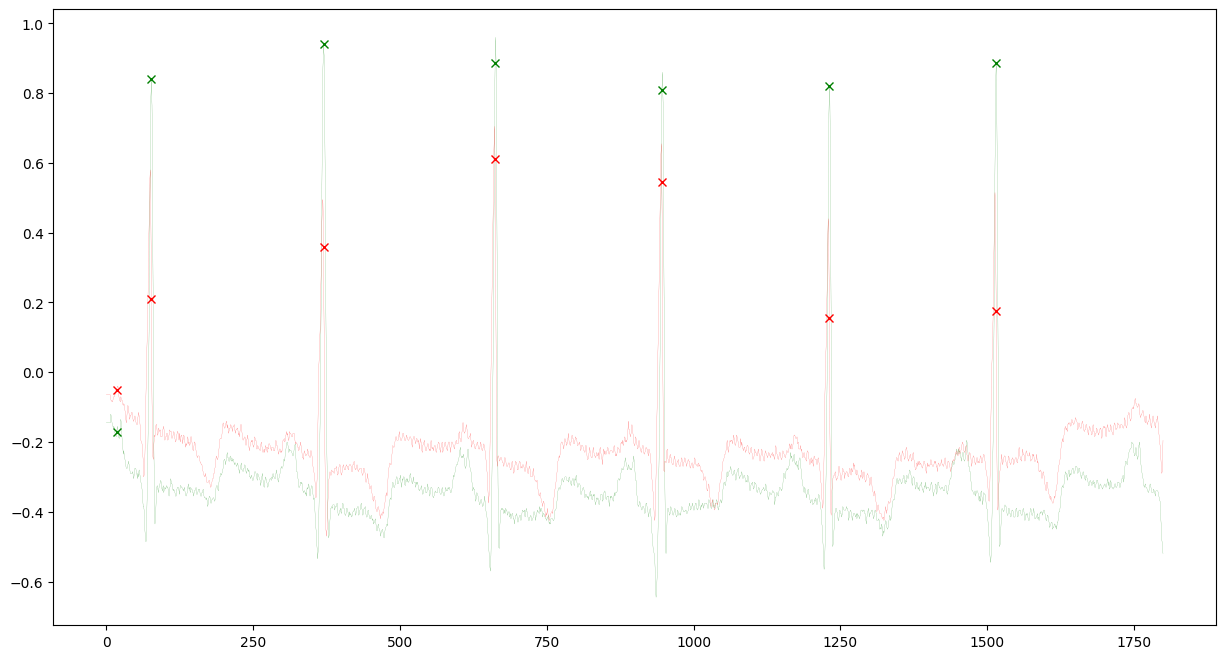

In [ ]:
patient_id = 100
secs = 5
samps = secs * fs
# Change: samps = secs * ecg_info["fs"] # hardcoded instead of using the fs from the data, since it is fixed

upto = bisect(rpeaks[patient_id], samps)
signal_0, peaks_0 = lead0[patient_id], rpeaks[patient_id]
signal_1, peaks_1 = lead1[patient_id], rpeaks[patient_id] # Added: lead1 is the second lead

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal_0[:samps], linewidth=0.1, color='green')
plt.plot(signal_1[:samps], linewidth=0.1, color='red')
plt.plot(peaks_0[:upto], signal_0[peaks_0[:upto]], marker="x", linestyle="", color='green')
plt.plot(peaks_1[:upto], signal_1[peaks_1[:upto]], marker="x", linestyle="", color='red')
plt.show()

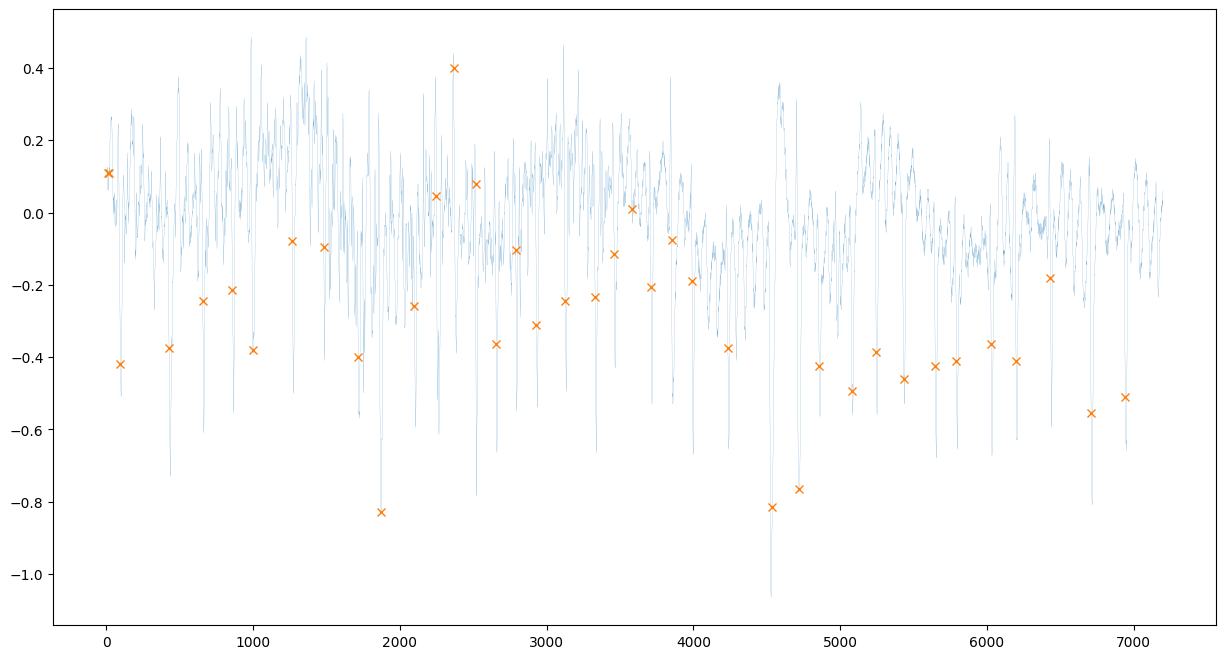

In [ ]:
patient_id = 203
secs = 20

samps = secs * fs
upto = bisect(rpeaks[patient_id], samps)
signal, peaks = lead1[patient_id], rpeaks[patient_id]

plt.figure(figsize=(15, 8), dpi=100)
plt.plot(signal[:samps], linewidth=0.1)
plt.plot(peaks[:upto]-2, signal[peaks[:upto]-2], marker="x", linestyle="")
plt.show()

# 03 Separate signals into beats and annotate

- **We only capture beats that are annotated in one of the classes given in the functions below.**
- **We don't capture the left-most and right-most beats.**
- **Beat classes are different from beat labels. Classes are only one of N, S, V, F, Q.**

In [51]:
def get_normal_beat_labels():
    """
    The MIT-BIH labels that are classified as healthy/normal. Check wfdb.Annotation documentation for description of labels.
    N: {N, L, R, e, j}. 
    """
    return np.array(["N", "L", "R", "e", "j"])

def get_abnormal_beat_labels():
    """
    The MIT-BIH labels that are classified as arrhythmia/abnormal. Check wfdb.Annotation documentation for description of labels.
    S: {S, A, J, a} - V: {V, E} - F: {F} - Q: {Q}
    """
    return np.array(["S", "A", "J", "a", "V", "E", "F", "Q"])

def get_beat_class(label):
    """
    A mapping from labels to classes, based on the rules described in get_normal_beat_labels() and get_abnormal_beat_labels().
    """
    if label in ["N", "L", "R", "e", "j"]:
        return "N"
    elif label in ["S", "A", "J", "a"]:
        return "S"
    elif label in ["V", "E"]:
        return "V"
    elif label == "F" or label == "Q":
        return label
    return None

In [52]:
def get_beats(patient_ids, signals, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1, matlab=False):
#def get_beats(patient_ids, signals, rpeaks, labels, beat_trio=True, centered=False, lr_offset=0.1, matlab=False):
    """
    For each patient:
    Converts its ECG signal to an array of valid beats, where each rpeak with a valid label is converted to a beat of length 128 by resampling (Fourier-Domain).
    Converts its labels to an array of valid labels, and a valid label is defined in the functions get_normal_beat_labels() and get_abnormal_beat_labels().
    Converts its valid labels to an array of classes, where each valid label is one of 5 classes, (N, S, V, F, Q).
    
    Parameters
    ----------
    beat_trio: bool, default=False
        If True, generate beats as trios.
        
    centered: bool, default=False
        Whether the generated beats have their peaks centered.
        
    lr_offset: float, default=0.1, range=[0, 1]
        A beat is extracted by finding the beats before and after it, and then offsetting by some samples. This parameter controls how many samples are
        offsetted. If the lower beat is L, and the current beat is C, then we offset by `lr_offset * abs(L - C)` samples.
        
    matlab: bool, default=False
        If True, dictionary keys become strings to be able to save the dictionary as a .mat file.
    """
    
    beat_length = 128
    get_key_name = lambda patient_id: f"patient_{patient_id}" if matlab else patient_id
    
    beat_data = {get_key_name(patient_id):{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
    
    for j, patient_id in enumerate(patient_ids):
        key_name = get_key_name(patient_id)
        
        # Filter out rpeaks that do not correspond to a valid label.
        valid_labels = np.concatenate((get_normal_beat_labels(), get_abnormal_beat_labels()))
        valid_idx = np.where(np.isin(labels[patient_id], valid_labels))[0]
        valid_rpeaks = rpeaks[patient_id][valid_idx]
        valid_labels = labels[patient_id][valid_idx]
        
        for i in range(1, len(valid_rpeaks) - 1):
            lpeak = valid_rpeaks[i - 1]
            cpeak = valid_rpeaks[i]
            upeak = valid_rpeaks[i + 1]
    
            if beat_trio:
                lpeak = int(lpeak - (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak + (lr_offset * abs(cpeak - upeak)))
            else:
                lpeak = int(lpeak + (lr_offset * abs(cpeak - lpeak)))
                upeak = int(upeak - (lr_offset * abs(cpeak - upeak)))
            
            if centered:
                ldiff = abs(lpeak - cpeak)
                udiff = abs(upeak - cpeak)
                diff = min(ldiff, udiff)
                
                # Take same number of samples from the center.
                beat = signals[patient_id][cpeak - diff:cpeak + diff + 1]
            else:
                beat = signals[patient_id][lpeak:upeak]
            
            # Resampling in the frequency domain instead of in the time domain (resample_poly)
            # beat = sp.signal.resample_poly(beat, beat_length, len(beat))
            beat = sp.signal.resample(beat, beat_length)
    
            # detrend the beat and normalize it.
            beat = sps.detrend(beat)
            beat = beat / np.linalg.norm(beat, ord=2)
        
            label = valid_labels[i]
        
            beat_data[key_name]["beats"].append(beat)
            beat_data[key_name]["class"].append(get_beat_class(label))
            beat_data[key_name]["label"].append(label)
        beat_data[key_name]["beats"] = np.stack(beat_data[key_name]["beats"])
        beat_data[key_name]["class"] = np.stack(beat_data[key_name]["class"])
        beat_data[key_name]["label"] = np.stack(beat_data[key_name]["label"])
        
        print_progress(j + 1, len(patient_ids), opt=[f"{patient_id}"])
    return beat_data

Generate single beats or beat trios and visualize
(Set `beat_trio=True` to generate beat-trios.)

In [61]:
beat_data = get_beats(patient_ids, lead0, rpeaks, labels, beat_trio=False, centered=False, lr_offset=0.1)
beat_data_trio = get_beats(patient_ids, lead0, rpeaks, labels, beat_trio=True, centered=False, lr_offset=0.1)

48/48 [====================] - 234


In [69]:
beat_data

{100: {'beats': array([[-0.03024875, -0.00817779, -0.01984587, ...,  0.033241  ,
           0.00027685, -0.01480269],
         [-0.01822005, -0.01540304, -0.02438463, ..., -0.03207176,
          -0.03768637, -0.0433033 ],
         [-0.01165083, -0.03115363, -0.02595843, ..., -0.02640448,
          -0.02916875, -0.03896504],
         ...,
         [-0.03968485, -0.03872239, -0.03920411, ..., -0.03969629,
          -0.03516211, -0.0505896 ],
         [-0.03610631, -0.04026123, -0.03522159, ..., -0.05704345,
          -0.05580564, -0.05910287],
         [-0.09061379, -0.04489519, -0.04724623, ..., -0.07697315,
          -0.04605489, -0.07292854]]),
  'class': array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1'),
  'label': array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')},
 101: {'beats': array([[-0.03163188, -0.0778288 , -0.06013206, ...,  0.03286979,
           0.01948678,  0.00435814],
         [-0.0738348 , -0.0918277 , -0.08490526, ...,  0.02505095,
           0.00836593, -

In [ ]:
# ADDED: get the number of accepted labels over all patients
from collections import Counter

label_counter = Counter()
for patient_data in beat_data.values():
    label_array = patient_data.get("label")
    if label_array is not None:
        label_counter.update(label_array.tolist())

dict(label_counter)

{'N': 74981,
 'A': 2544,
 'V': 7124,
 'Q': 32,
 'F': 802,
 'j': 229,
 'L': 8069,
 'a': 150,
 'J': 83,
 'R': 7250,
 'E': 106,
 'S': 2,
 'e': 16}

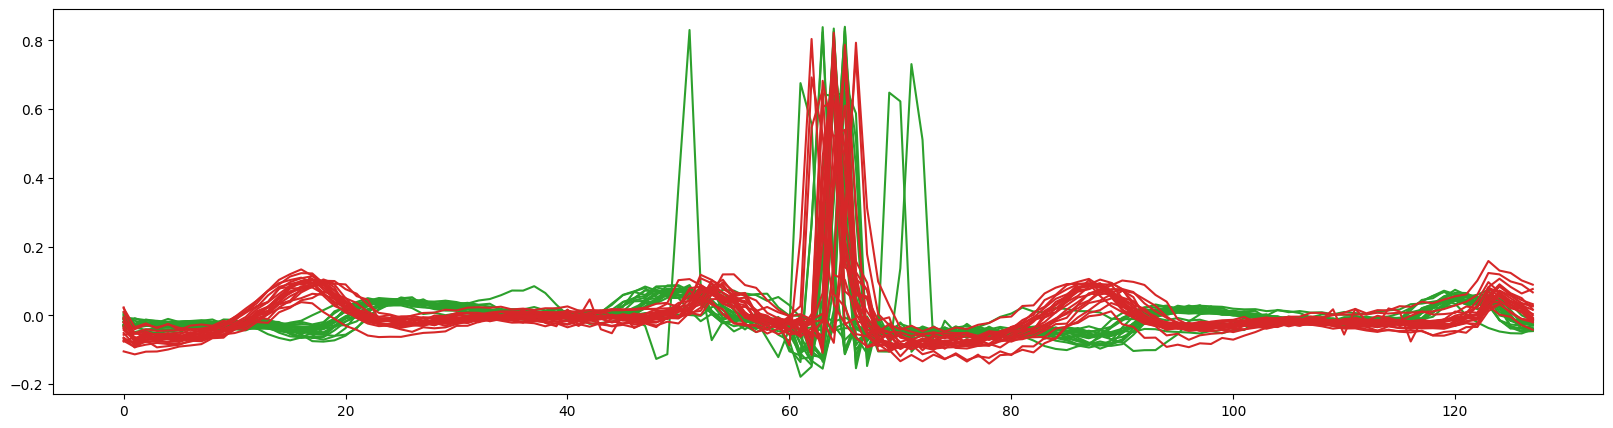

In [125]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data[100]["beats"][0:20].T, "C2") # green
plt.plot(beat_data[101]["beats"][0:20].T, "C3") # red
plt.show()

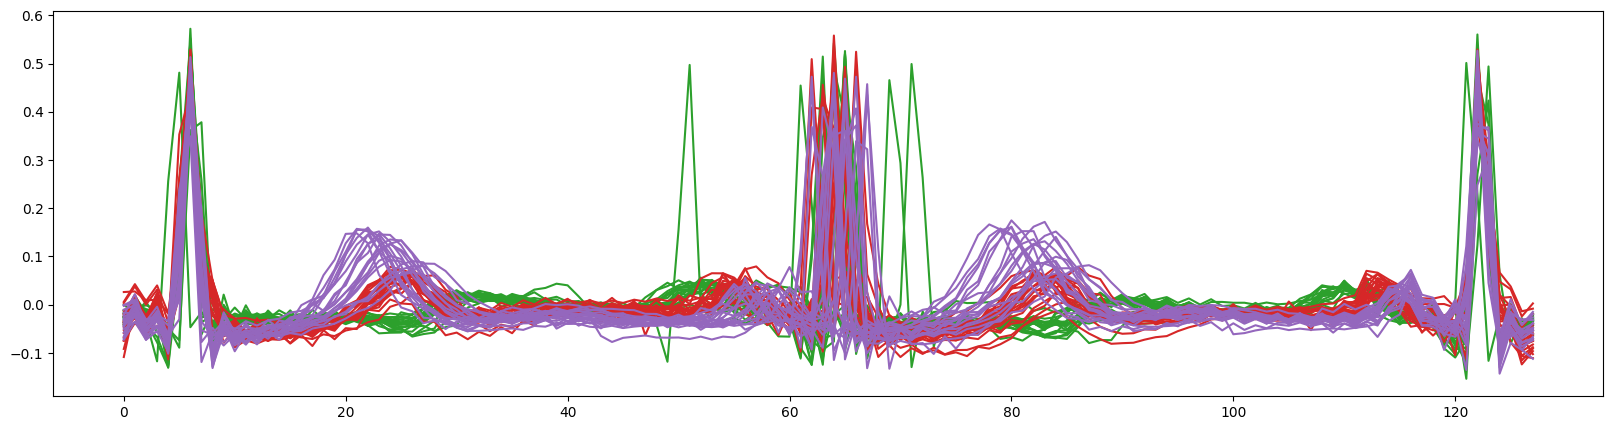

In [142]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data_trio[100]["beats"][0:20].T, "C2") # green
plt.plot(beat_data_trio[101]["beats"][0:20].T, "C3") # red
plt.plot(beat_data_trio[106]["beats"][0:20].T, "C4") # purple
plt.show()

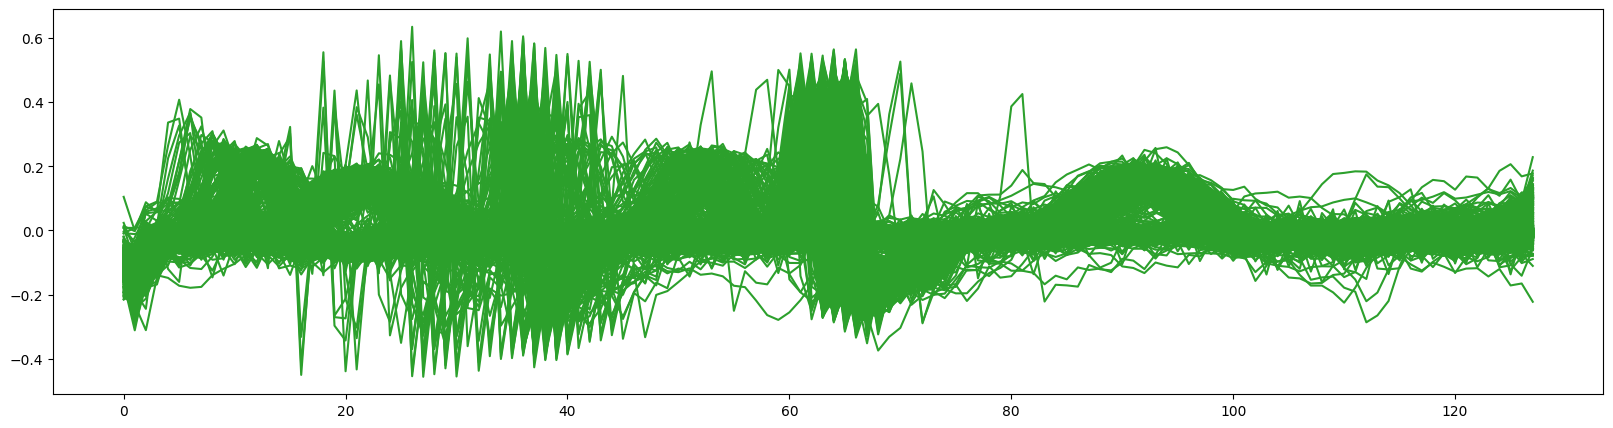

In [137]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data[232]["beats"][beat_data[232]["class"] == "S"].T, "C2")
plt.show()

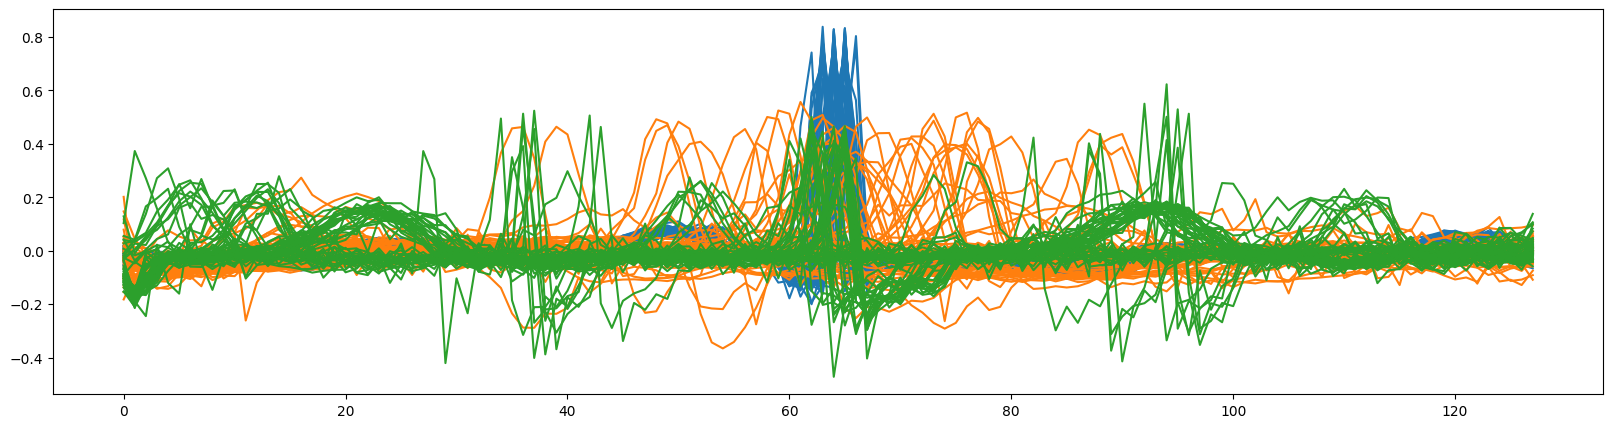

In [143]:
plt.figure(figsize=(20, 5))
plt.plot(beat_data[100]["beats"][50:100].T, "C0") # blue
plt.plot(beat_data[203]["beats"][50:100].T, "C1") # orange
plt.plot(beat_data[232]["beats"][50:100].T, "C2") # green
plt.show()

# 04 Separate data into training and test set

Find the sample that corresponds to the 5 minute mark, and take the healthy signals before it.

Careful:
- **We skipped the first beat (because there is no beat to its left).**
- **When we say `idx = bisect(rpeaks[patient_id], fivemin)`, we get the index of the beat that is the first beat after 5 minutes has passed.**
- **But since the first beat is skipped, that index is actually the second beat after 5 minutes has passed in our data.**
- **We should say `idx = bisect(rpeaks[patient_id], fivemin) - 1` to get the correct index.**

## Find 5 min mark

In [73]:
# Commented: this does not save the index, but the position of the index in the rpeaks array.
fivemin = fs * 60 * 5 # 108.000
fivemin_index = []


for patient_id in patient_ids:
    idx = bisect(rpeaks[patient_id], fivemin) - 1
    fivemin_index.append(idx)

In [74]:
fivemin_index[0] # index position of the 5 min mark for patient 100

371

In [75]:
rpeaks[100][370:380] # indexes of the rpeaks around the 5 min mark

array([107453, 107750, 108045, 108342, 108643, 108926, 109199, 109486,
       109772, 110076])

In [80]:
beat_data[100]["class"]

array(['N', 'N', 'N', ..., 'N', 'N', 'N'], dtype='<U1')

## Split datasets

In [ ]:
# CHANGE: moved code into a function to handle single and trio beats simoultaneously
def split_beat_data(beat_data, fivemin_index):
    """
    Splits the beat data into two dictionaries: one with beats under 5 minutes and one with the remaining beats.
    """
    # Create empty dictionaries for each patient
    fivemin_beat_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}
    remaining_beat_data = {patient_id:{"beats":[], "class":[], "label":[]} for patient_id in patient_ids}

    for i, patient_id in enumerate(patient_ids):

        # normal beats under 5 minutes
        normal_idx = np.where(beat_data[patient_id]["class"][0:fivemin_index[i]] == "N")[0]
        # all other beats
        other_idx = np.setdiff1d(np.arange(0, len(beat_data[patient_id]["class"])), normal_idx)
        
        fivemin_beat_data[patient_id]["beats"] = beat_data[patient_id]["beats"][normal_idx, :]
        fivemin_beat_data[patient_id]["class"] = beat_data[patient_id]["class"][normal_idx]
        fivemin_beat_data[patient_id]["label"] = beat_data[patient_id]["label"][normal_idx]

        assert len(normal_idx) + len(other_idx) == len(beat_data[patient_id]["class"]), "Some beats are not taken into account!"

        remaining_beat_data[patient_id]["beats"] = beat_data[patient_id]["beats"][other_idx, :]
        remaining_beat_data[patient_id]["class"] = beat_data[patient_id]["class"][other_idx]
        remaining_beat_data[patient_id]["label"] = beat_data[patient_id]["label"][other_idx]

        assert np.count_nonzero(fivemin_beat_data[patient_id]["class"] != "N") == 0, "Abnormal beat misplaced!"

    return fivemin_beat_data, remaining_beat_data

In [83]:
fivemin_beat_data, remaining_beat_data = split_beat_data(beat_data, fivemin_index)
fivemin_beat_data_trio, remaining_beat_data_trio = split_beat_data(beat_data_trio, fivemin_index)

# 05 save data
Uncomment to store the data

In [ ]:
# DATASET_PATH = osj("..", "data_single", "dataset_beats")

# with open(osj(DATASET_PATH, "5min_normal_beats.pkl"), "wb") as f:
#     pickle.dump(fivemin_beat_data, f)
    
# with open(osj(DATASET_PATH, "25min_beats.pkl"), "wb") as f:
#     pickle.dump(remaining_beat_data, f)
    
# with open(osj(DATASET_PATH, "30min_beats.pkl"), "wb") as f:
#     pickle.dump(beat_data, f) 


In [ ]:
# DATASET_PATH = osj("..", "data_trio", "dataset_beats") 

# with open(osj(DATASET_PATH, "5min_normal_beats.pkl"), "wb") as f:
#     pickle.dump(fivemin_beat_data_trio, f)
    
# with open(osj(DATASET_PATH, "25min_beats.pkl"), "wb") as f:
#     pickle.dump(remaining_beat_data_trio, f)
    
# with open(osj(DATASET_PATH, "30min_beats.pkl"), "wb") as f:
#     pickle.dump(beat_data_trio, f) 